## Explicación de los datos

Este conjunto de datos contiene información agrícola para 3500 de muestras, con el objetivo de predecir el rendimiento de los cultivos (en toneladas por hectárea) basado en varios factores. El conjunto de datos puede ser utilizado para tareas de regresión en el aprendizaje automático, especialmente para predecir la productividad de los cultivos.

- **Región**: La región geográfica donde se cultiva el cultivo (Norte, Este, Sur, Oeste).  
- **Tipo_de_Suelo**: El tipo de suelo en el que se planta el cultivo (Arcilloso, Arenoso, Franco, Limoso, Turboso, Calcáreo).  
- **Cultivo**: El tipo de cultivo sembrado (Trigo, Arroz, Maíz, Cebada, Soja, Algodón).  
- **Lluvia_mm**: La cantidad de lluvia recibida en milímetros durante el período de crecimiento del cultivo.  
- **Temperatura_Celsius**: La temperatura promedio durante el período de crecimiento del cultivo, medida en grados Celsius.  
- **Fertilizante_Usado**: Indica si se aplicó fertilizante (Verdadero = Sí, Falso = No).  
- **Riego_Usado**: Indica si se usó riego durante el período de crecimiento del cultivo (Verdadero = Sí, Falso = No).  
- **Condición_Climática**: La condición climática predominante durante la temporada de crecimiento (Soleado, Lluvioso, Nublado).  
- **Días_para_Cosecha**: El número de días que se tarda en cosechar el cultivo después de la siembra.  
- **Rendimiento_toneladas_por_hectárea**: El rendimiento total del cultivo producido, medido en toneladas por hectárea.


In [1]:
import pandas as pd
import numpy as np

# Modelo
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


# Visualización
from sklearn.tree import export_graphviz
from IPython.display import Image
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns

In [2]:
data=pd.read_csv("crop_yield2.csv")
data.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563 entries, 0 to 3562
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Region                  3563 non-null   object 
 1   Soil_Type               3563 non-null   object 
 2   Crop                    3563 non-null   object 
 3   Rainfall_mm             3563 non-null   float64
 4   Temperature_Celsius     3563 non-null   float64
 5   Fertilizer_Used         3563 non-null   bool   
 6   Irrigation_Used         3563 non-null   bool   
 7   Weather_Condition       3563 non-null   object 
 8   Days_to_Harvest         3563 non-null   int64  
 9   Yield_tons_per_hectare  3563 non-null   float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 229.8+ KB


In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = data.drop('Yield_tons_per_hectare', axis=1)
y = data['Yield_tons_per_hectare'] 

# Dividimos los datos en entrenamiento y prueba antes de preprocesarlos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificamos las columnas categóricas
categorical_columns = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']

# Creamos el preprocesador que convierte las columnas categóricas usando OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        #handle_unknown='ignore' interesante si trabajas con datos en vivo y en los que pueden aparecer categorías inesperadas
    ],
    remainder='passthrough',  # Las demás columnas (numéricas) se dejan como están
    force_int_remainder_cols=False  # las columnas que no se transforman siguen con su tipo de dato original
)
# Definir el pipeline para preprocesar los datos y definir el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Entrenar el pipeline con los datos de entrenamiento
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Region', 'Soil_Type',
                                                   'Crop',
                                                   'Weather_Condition'])])),
                ('regressor', RandomForestRegressor())])

In [5]:
#predicciones
y_pred = pipeline.predict(X_test)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluamos la precisión usando métricas de regresión
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

Mean Squared Error: 0.2818346101080906
Mean Absolute Error: 0.4250861399364851
R2 Score: 0.8952001455484082


In [7]:
# mostramos un dataframe con los resultados de las predicciones
results = pd.DataFrame({'Yield_tons_per_hectare': y_test, 'Predicted_Yield_tons_per_hectare': y_pred})
results.head(30)

,Yield_tons_per_hectare,Predicted_Yield_tons_per_hectare
2272,1.414402,1.908914
184,3.034155,4.502223
2725,5.082701,5.525594
1361,5.689484,4.870872
2856,2.335728,2.346860
764,3.294209,3.742285
211,7.980998,7.679040
179,2.248346,2.491744
1407,3.868432,3.093385
881,3.791777,3.892556


In [8]:
rf_model = pipeline.named_steps['regressor']

In [9]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

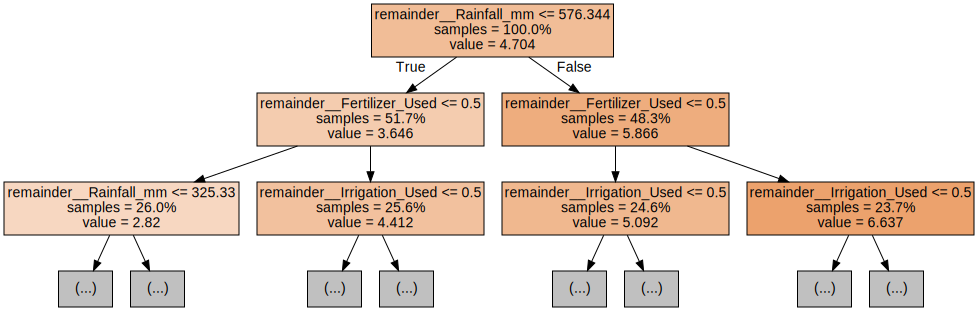

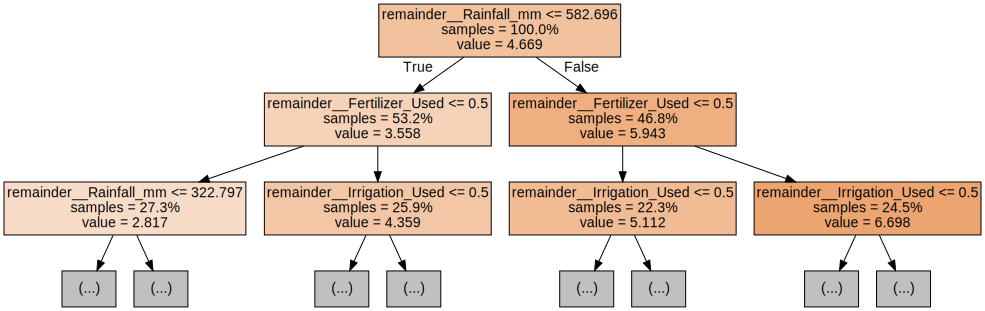

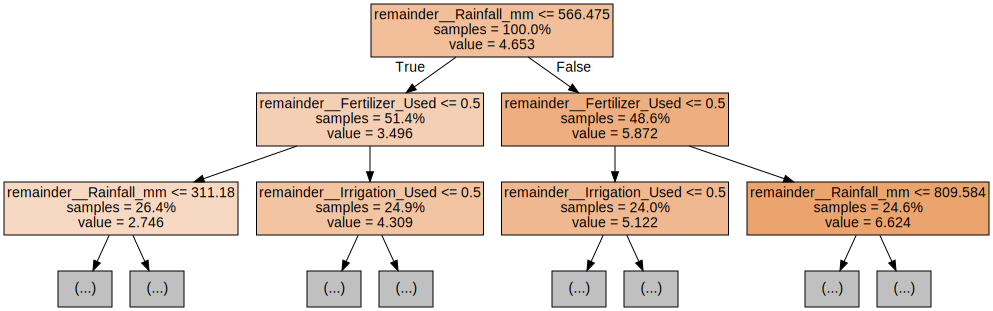

In [10]:
for i in range(3):
    tree = rf_model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=feature_names,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [11]:
# Definir el espacio de búsqueda para los  hiperparámetros  Esta versión puede ralentizarse mucho...
param_dist = {
    'regressor__n_estimators': randint(10, 60),    # Número de árboles en RandomForest
    'regressor__max_depth': randint(1, 20),          # Profundidad máxima de los árboles
    'regressor__min_samples_split': randint(2, 20),  # Mínimas muestras para dividir un nodo
    'regressor__min_samples_leaf': randint(1, 20),   # Mínimas muestras en una hoja
    'regressor__bootstrap': [True, False]            # Usar muestreo bootstrap o no
}

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=3, cv=3, verbose=2, random_state=42)

# Ajustar el modelo con los datos de entrenamiento
random_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros encontrados:", random_search.best_params_)

# Mejor modelo
best_rf = random_search.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END regressor__bootstrap=True, regressor__max_depth=15, regressor__min_samples_leaf=11, regressor__min_samples_split=9, regressor__n_estimators=30; total time=   0.1s
[CV] END regressor__bootstrap=True, regressor__max_depth=15, regressor__min_samples_leaf=11, regressor__min_samples_split=9, regressor__n_estimators=30; total time=   0.1s
[CV] END regressor__bootstrap=True, regressor__max_depth=15, regressor__min_samples_leaf=11, regressor__min_samples_split=9, regressor__n_estimators=30; total time=   0.1s
[CV] END regressor__bootstrap=True, regressor__max_depth=19, regressor__min_samples_leaf=11, regressor__min_samples_split=12, regressor__n_estimators=33; total time=   0.1s
[CV] END regressor__bootstrap=True, regressor__max_depth=19, regressor__min_samples_leaf=11, regressor__min_samples_split=12, regressor__n_estimators=33; total time=   0.1s
[CV] END regressor__bootstrap=True, regressor__max_depth=19, regressor__min_sam

In [12]:
y_pred=best_rf.predict(X_test) #realizamos predicciones sobre el conjunto de prueba

In [13]:
# Evaluamos la precisión usando métricas de regresión
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

Mean Squared Error: 0.26162989525867675
Mean Absolute Error: 0.4103067365725934
R2 Score: 0.9027132440093899


In [14]:
# mostramos un dataframe con los resultados de las predicciones
results = pd.DataFrame({'Yield_tons_per_hectare': y_test, 'Predicted_Yield_tons_per_hectare': y_pred})
results.head(30)

,Yield_tons_per_hectare,Predicted_Yield_tons_per_hectare
2272,1.414402,1.584054
184,3.034155,4.586858
2725,5.082701,5.457460
1361,5.689484,5.060679
2856,2.335728,2.288239
764,3.294209,3.545721
211,7.980998,7.758820
179,2.248346,2.545879
1407,3.868432,3.147252
881,3.791777,3.679442


In [15]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Crear dos nuevos modelos de regresión
model1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
model2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])



In [16]:
# Crear un VotingRegressor con los tres modelos
voting_regressor = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('lr', model1),
    ('svr', model2)
])

# Entrenar el VotingRegressor con los datos de entrenamiento
voting_regressor.fit(X_train, y_train)

# Realizar predicciones con el VotingRegressor
y_pred_voting = voting_regressor.predict(X_test)

# Evaluar el VotingRegressor usando métricas de regresión
mse_voting = mean_squared_error(y_test, y_pred_voting)
mae_voting = mean_absolute_error(y_test, y_pred_voting)
r2_voting = r2_score(y_test, y_pred_voting)

print("Voting Regressor Mean Squared Error:", mse_voting)
print("Voting Regressor Mean Absolute Error:", mae_voting)
print("Voting Regressor R2 Score:", r2_voting)

Voting Regressor Mean Squared Error: 0.35961446513761075
Voting Regressor Mean Absolute Error: 0.4853724283670493
Voting Regressor R2 Score: 0.8662778017552403


In [17]:
from sklearn.ensemble import StackingRegressor

# Definir los estimadores base
estimators = [
    ('rf', best_rf),
    ('lr', model1),
    ('svr', model2)
]

# Crear el StackingRegressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor())

# Entrenar el StackingRegressor con los datos de entrenamiento
stacking_regressor.fit(X_train, y_train)

# Realizar predicciones con el StackingRegressor
y_pred_stacking = stacking_regressor.predict(X_test)

# Evaluar el StackingRegressor usando métricas de regresión
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

print("Stacking Regressor Mean Squared Error:", mse_stacking)
print("Stacking Regressor Mean Absolute Error:", mae_stacking)
print("Stacking Regressor R2 Score:", r2_stacking)

Stacking Regressor Mean Squared Error: 0.30128222062191223
Stacking Regressor Mean Absolute Error: 0.43320104566132406
Stacking Regressor R2 Score: 0.8879685754069764


In [18]:
from xgboost import XGBRegressor

# Crear un nuevo modelo de regresión con XGBoost
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

# Entrenar el modelo XGBoost con los datos de entrenamiento
xgb_model.fit(X_train, y_train)

# Realizar predicciones con el modelo XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el modelo XGBoost usando métricas de regresión
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Mean Squared Error:", mse_xgb)
print("XGBoost Mean Absolute Error:", mae_xgb)
print("XGBoost R2 Score:", r2_xgb)

XGBoost Mean Squared Error: 0.3107235195746699
XGBoost Mean Absolute Error: 0.44374249118038145
XGBoost R2 Score: 0.8844578399593197
